In [1]:
import pandas as pd
import os

# List files in dataset\processed_data

files = os.listdir('dataset/processed_data')
print(files)

# Read the files into a dataframe
for idx, file in enumerate(files):
    if idx == 0:
        df = pd.read_csv('dataset/processed_data/' + file, na_values=['', ' ', 'No information found.'])
    else:
        df = pd.concat([df, pd.read_csv('dataset/processed_data/' + file, na_values=['', ' ', 'No information found.'])], ignore_index=True)

['10_MPlus_ADAM_QA.csv', '11_MPlusDrugs_QA.csv', '12_MPlusHerbsSupplements_QA.csv', '1_CancerGov_QA.csv', '2_GARD_QA.csv', '3_GHR_QA.csv', '4_MPlus_Health_Topics_QA.csv', '5_NIDDK_QA.csv', '6_NINDS_QA.csv', '7_SeniorHealth_QA.csv', '8_NHLBI_QA_XML.csv', '9_CDC_QA.csv']


In [2]:
# Quedarse con las filas sin nan
df = df.dropna()
# Quedarse con las 300 primeras filas
df = df.head(50)

df

,question,question_id,question_type,answer
0,What is (are) A guide to clinical trials for c...,0000001-1,information,"If you have cancer, a clinical trial may be an..."
5,Do you have information about A guide to herba...,0000002-1,information,Herbal remedies are plants used like a medicin...
6,What is (are) A1C test ?,0000003-1,information,A1C is a lab test that shows the average level...
8,What is (are) Aarskog syndrome ?,0000004-1,information,Aarskog syndrome is a very rare disease that a...
9,What causes Aarskog syndrome ?,0000004-2,causes,Aarskog syndrome is a genetic disorder that is...
10,What are the symptoms of Aarskog syndrome ?,0000004-3,symptoms,Symptoms of this condition include: Belly butt...
11,How to diagnose Aarskog syndrome ?,0000004-4,exams and tests,These tests may be done: Genetic testing for m...
12,What are the treatments for Aarskog syndrome ?,0000004-5,treatment,Moving the teeth may be done to treat some of ...
13,Where to find support for people with Aarskog ...,0000004-6,support groups,More information and support for people with A...
14,What is the outlook for Aarskog syndrome ?,0000004-7,outlook,"Some people may have some mental slowness, but..."


<Axes: >

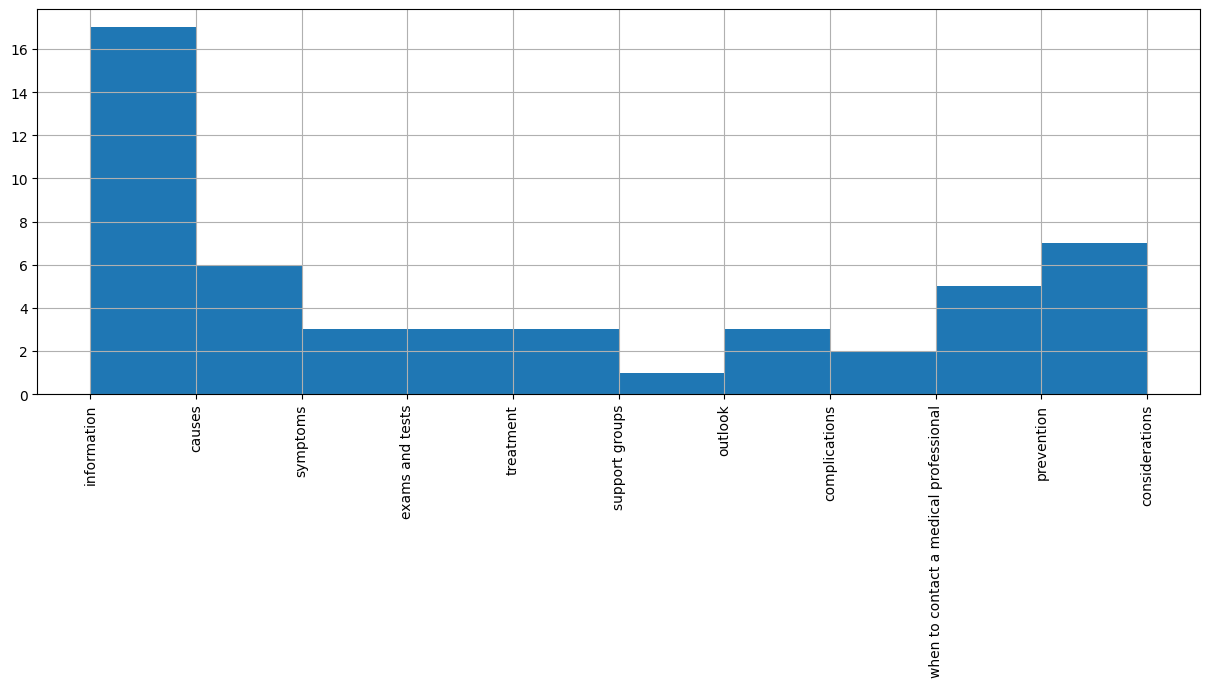

In [3]:
# Mostrar histograma de question_type para ver cuantos tipos de preguntas hay con etiquetas verticales

df.question_type.hist(figsize=(15,5), xrot=90)


In [4]:
import faiss
from faiss import write_index
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

# Movemos el modelo y los datos al dispositivo que corresponda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Función para obtener word embeddings con BERT
def get_bert_embeddings(documents):
  tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
  model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT').to(device)
  embeddings = []
  for doc in documents:
    inputs = tokenizer(doc, return_tensors='pt', truncation=True, padding=True, max_length=256).to(device)
    with torch.no_grad():
      outputs = model(**inputs)
    doc_embedding = outputs.last_hidden_state.mean(1).squeeze().cpu().numpy()
    embeddings.append(doc_embedding)
  return np.array(embeddings)

# Función para crear el índice FAISS
def create_faiss_index(embeddings):
  dimension = embeddings.shape[1]
  index = faiss.IndexFlatL2(dimension)
  index.add(embeddings)
  return index


documents = df.answer.tolist()  # Los textos están en la columna "title"
print(documents)
# Procesamos los documentos para obtener los word embeddings
embeddings = get_bert_embeddings(documents)

# Crea el índice FAISS con los embeddings
index = create_faiss_index(embeddings)

c:\Users\pablo\anaconda3\envs\APLN\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['If you have cancer, a clinical trial may be an option for you. A clinical trial is a study using people who agree to participate in new tests or treatments. Clinical trials help researchers know whether a new treatment works well and is safe. Trials are available for many cancers and all stages of cancer, not just advanced cancer.  If you join a trial, you may get treatment that can help you. Plus, you will help others to learn more about your cancer as well as new tests or treatments. There are many things to consider before joining a trial. Learn about why you might want to enroll in a clinical trial and where to find one.', 'Herbal remedies are plants used like a medicine. People use herbal remedies to help prevent or cure disease. They use them to get relief from symptoms, boost energy, relax, or lose weight.  Herbal remedies are not regulated or tested like medicines.  How can you know what you are getting and if it is useful? This guide can help you choose and use herbals safel

In [ ]:
# Función para obtener los embeddings de una consulta de texto
def get_query_embedding(query_text):
    tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
    model = AutoModel.from_pretrained('distilbert/distilbert-base-uncased').to(device)
    inputs = tokenizer(query_text, return_tensors='pt', truncation=True, padding=True, max_length=256).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    query_embedding = outputs.last_hidden_state.mean(1).squeeze().cpu().numpy()
    return query_embedding

# Ejemplo de consulta
query_text = "Do I need to see a doctor for Abdominal mass ?"
query_embedding = get_query_embedding(query_text)
query_vector = np.expand_dims(query_embedding, axis=0)
print(f'Query vector: {query_vector}')
# Realiza la búsqueda en el índice FAISS
D, I = index.search(query_vector, k=5)  # Busca los 5 documentos más similares

print("Consulta realizada con el texto:", query_text)
print("Documentos más similares:")
for i, idx in enumerate(I[0], start=1):
    print(f"{i}: Documento {idx} con una distancia de {D[0][i-1]}")
    print("Contenido del documento:", documents[idx])

: 